**DATA SET LINK**

Link to the UCI repository:
           https://archive.ics.uci.edu/dataset/471/electrical+grid+stability+simulated+data  


# Introduction

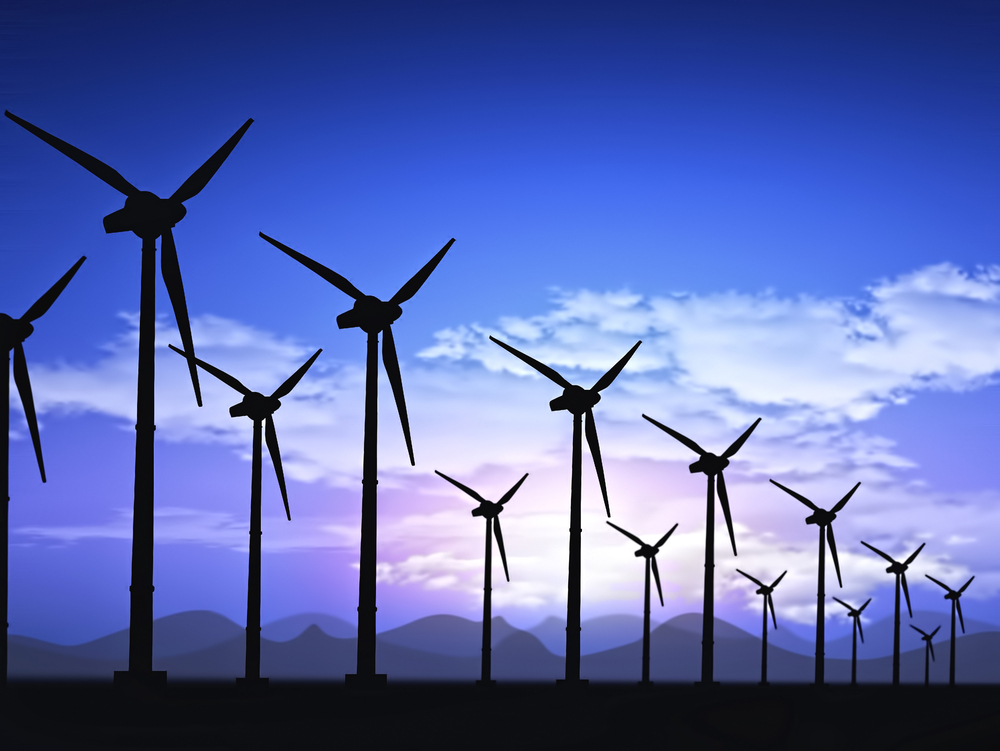

In [182]:
from IPython.display import Image
Image('/content/img.jpg', width=600, height=None)



In this project, we are working with a dataset that was specifically simulated to analyze the feasibility of maintaining grid stability under Distributed Smart Grid Control (DSGC). The dataset assumes a 4-node architecture comprising one electricity producer and three consumers. Key details of the dataset include:

- **Total Instances**: 10,000
- **Attributes**: 12

**Attributes Description**

1. **Power (p[x])**:
    - `p1 to p4`: Power produced or consumed by each node.
    - `p1`: Calculated as the absolute value of the sum of `p2`, `p3`, and `p4`.

2. **Adaptation Willingness (g[x])**:
    - `g1 to g4`: Indicates how willing each node is to adapt their consumption or production per second.
    - This value is proportional to the price elasticity (gamma).

3. **Adaptation Time (tau[x])**:
    - `tau1 to tau4`: The time it takes for each node to adapt their production or consumption, measured in seconds.

- `p1`, `g1`, and `tau1` are specifically related to the electricity producer, while the remaining values pertain to the electricity consumers.

**Target Variables**

- **stab**: A numerical value representing grid stability (a positive value indicates instability).
- **stabf**: A categorical version of `stab`, simplifying the stability status.


# Libraries


In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
import math
from tqdm import tqdm
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, f1_score, roc_auc_score

import seaborn as sns
from sklearn.model_selection import train_test_split
import random
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action='ignore',category=FutureWarning)
warnings.simplefilter(action='ignore',category=RuntimeWarning)

In [184]:
smart_grid_orig = pd.read_csv("/content/Data_for_UCI_named.csv")
smart_grid = smart_grid_orig.copy()

# Functions

In [185]:
def unique(smart_grid):
 for col in smart_grid.columns:
  unique_values = smart_grid[col].explode().unique()
  typee = smart_grid[col].dtype
  if len(unique_values) > 50:
   print(f"{col} has {len(unique_values)} unique values")
  else:
    print(f"{col} contains: {', '.join(map(str, unique_values))}")

def missing(smart_grid):
  missing_count = smart_grid.isnull().sum()
  total_values = smart_grid.shape[0]
  missing_percentage = (missing_count / total_values) * 100
  missing_data_summary = pd.DataFrame({
      '\033[1mMissing Count\033[0m': missing_count,
      '\033[1mMissing Percentage\033[0m': missing_percentage
  })
  print(missing_data_summary)

def desc_cols(smart_grid):
  numeric_cols = smart_grid.columns[smart_grid.dtypes!='object']
  categorical_cols = smart_grid.columns[smart_grid.dtypes=='object']
  print("\033[1mNumber of Numerical Cols",len(numeric_cols),"\033[0m")
  print(list(numeric_cols))
  print('-'*85)
  print("\033[1mNumber of Catageroical Cols",len(categorical_cols),"\033[0m")
  print(list(categorical_cols))

def check_outliers(df):
    outliers_dict = {}
    for col in df.columns:
        # Calculate Q1, Q3, and IQR for each column
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1

        # Define bounds for outliers
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identifying the outliers in the column
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]

        # Storing the results in the dictionary
        outliers_dict[col] = {'count': len(outliers)}

    # Return the dictionary containing outlier information for each column
    return outliers_dict

def scaling(df):
  scaler = StandardScaler()
  return scaler,pd.DataFrame(scaler.fit_transform(df))


# EDA

In [186]:
smart_grid.head()

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,unstable
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,stable
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,unstable
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,unstable
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,unstable


In [187]:
desc_cols(smart_grid)

Number of Numerical Cols 13 
['tau1', 'tau2', 'tau3', 'tau4', 'p1', 'p2', 'p3', 'p4', 'g1', 'g2', 'g3', 'g4', 'stab']
-------------------------------------------------------------------------------------
Number of Catageroical Cols 1 
['stabf']


In [188]:
unique(smart_grid)

tau1 has 10000 unique values
tau2 has 10000 unique values
tau3 has 10000 unique values
tau4 has 10000 unique values
p1 has 10000 unique values
p2 has 10000 unique values
p3 has 10000 unique values
p4 has 10000 unique values
g1 has 10000 unique values
g2 has 10000 unique values
g3 has 10000 unique values
g4 has 10000 unique values
stab has 10000 unique values
stabf contains: unstable, stable


Our DataSet has 10,000 features and based on the output we can observe Every Column has Unique Values

In [189]:
missing(smart_grid)

       Missing Count  Missing Percentage
tau1                       0                         0.0
tau2                       0                         0.0
tau3                       0                         0.0
tau4                       0                         0.0
p1                         0                         0.0
p2                         0                         0.0
p3                         0                         0.0
p4                         0                         0.0
g1                         0                         0.0
g2                         0                         0.0
g3                         0                         0.0
g4                         0                         0.0
stab                       0                         0.0
stabf                      0                         0.0


There are no missing values in the Data

In [190]:
stab_stable = max(smart_grid.query("stabf == 'stable'")["stab"]) < 0
stab_unstable = min(smart_grid.query("stabf == 'unstable'")["stab"]) > 0
assert (stab_stable & stab_unstable), "unexpected stab relationship"

print(" `stab` values of less than 0 are labelled 'stable' and greater than zero are lebelled 'unstable' in `stab`.")

 `stab` values of less than 0 are labelled 'stable' and greater than zero are lebelled 'unstable' in `stab`.


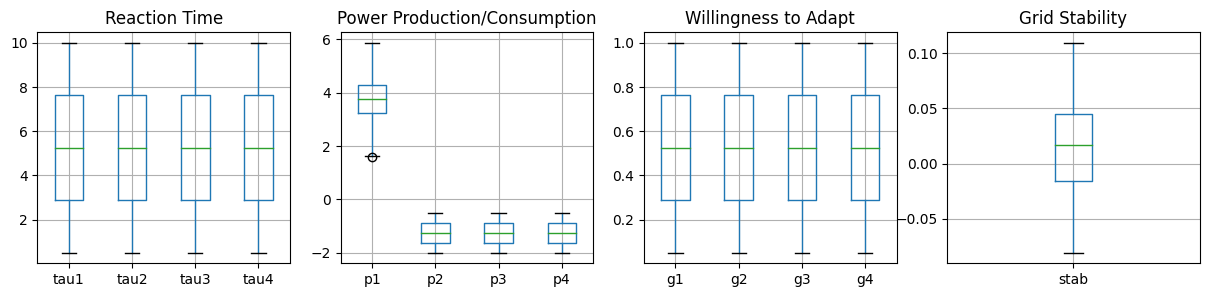

In [191]:
fig, axs = plt.subplots(1, 4, figsize=(15, 3))
feature_groups = ["tau", "p", "g", "stab"]
titles = ["Reaction Time", "Power Production/Consumption",
          "Willingness to Adapt", "Grid Stability"]

for i, feature_group in enumerate(feature_groups):
    if feature_group != "stab":  # For 'tau', 'p', 'g'
        columns = [feature_group + str(j + 1) for j in range(4)]
    else:  # For 'stab'
        columns = [feature_group]

    smart_grid_orig.boxplot(column=columns, ax=axs[i])

    axs[i].set(title=titles[i])

plt.show()


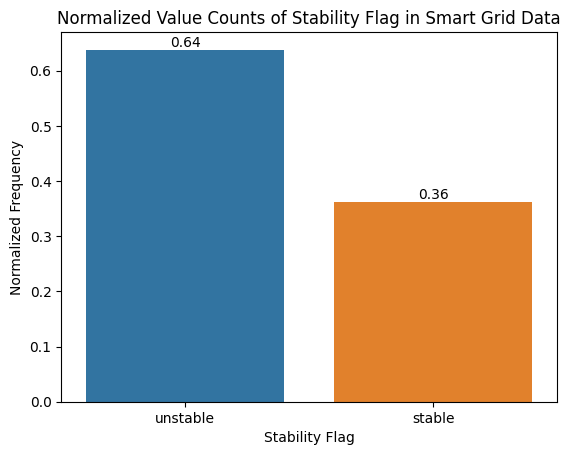

In [192]:
import matplotlib.pyplot as plt

normalized_value_counts = smart_grid['stabf'].value_counts(normalize=True)
sns.barplot(x=normalized_value_counts.index, y=normalized_value_counts.values)

plt.xlabel('Stability Flag')
plt.ylabel('Normalized Frequency')
plt.title('Normalized Value Counts of Stability Flag in Smart Grid Data')

for index, value in enumerate(normalized_value_counts.values):
    plt.text(index, value, f'{value:.2f}', ha='center', va='bottom')

plt.show()



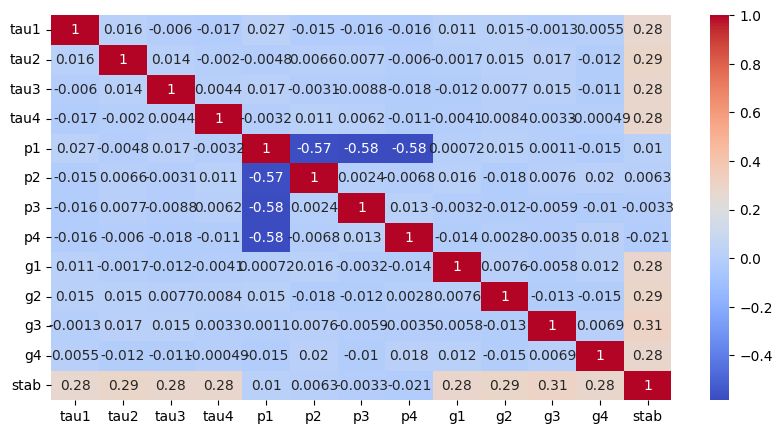

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the size of the figure
plt.figure(figsize=(10, 5))

# Compute the correlation matrix
corr = smart_grid.corr()

# Generate a heatmap
sns.heatmap(corr, annot=True, cmap='coolwarm')

# Show the plot
plt.show()


## Correlation Matrix Heatmap Observations

### Negative Correlations
- Variables `p1`, `p2`, `p3`, and `p4` exhibit **moderate to strong negative correlations** with each other, indicating that as one variable increases, the others tend to decrease.

### Positive Correlations
- Variables `g1`, `g2`, `g3`, and `g4` demonstrate **positive correlations** with stab, which suggests that these variables tend to increase together.

### Stability Variable Correlations
- The `stab` variable displays a **weak to moderate positive correlation** with `tau1`, `tau2`, `tau3`, and `tau4`, implying a slight to moderate tendency to move together.
- There is **almost no correlation** between the `stab` variable and `p1`, `p2`, `p3`, and `p4`, suggesting that changes in `stab` do not consistently relate to changes in these variables.

p1 has corelation with p2, p3, p4

**Checking for multicollinearity**

In [194]:
features = smart_grid.drop(["stab", "stabf"], axis=1).columns

(pd.DataFrame({
    "variables": smart_grid[features].columns,
    "VIF": [VIF(smart_grid[features].values, ind)
            for ind in range(len(features))]
})
 .rename({"variables": ""}, axis=1)

 .set_index("")
 .transpose()
)

,tau1,tau2,tau3,tau4,p1,p2,p3,p4,g1,g2,g3,g4
VIF,4.411883,4.373177,4.387577,4.342155,inf,inf,inf,inf,4.358228,4.39541,4.3677,4.321428


From the above we can see that both pearson and variance inflation factor states power column may be collinear and having a relationship power1 = abs(power2 + power3 + power4). So we can take out power1 column

# PreProcessing

In [195]:
smart_grid = smart_grid_orig.assign(stabf = lambda x: x.stabf.replace({"unstable": 0, "stable": 1}))

smart_grid.columns = (smart_grid.columns
                      .str.replace("tau", "delay")
                      .str.replace("p", "power")
                      .str.replace("g", "adapt"))

In [196]:
smart_grid.head()

,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


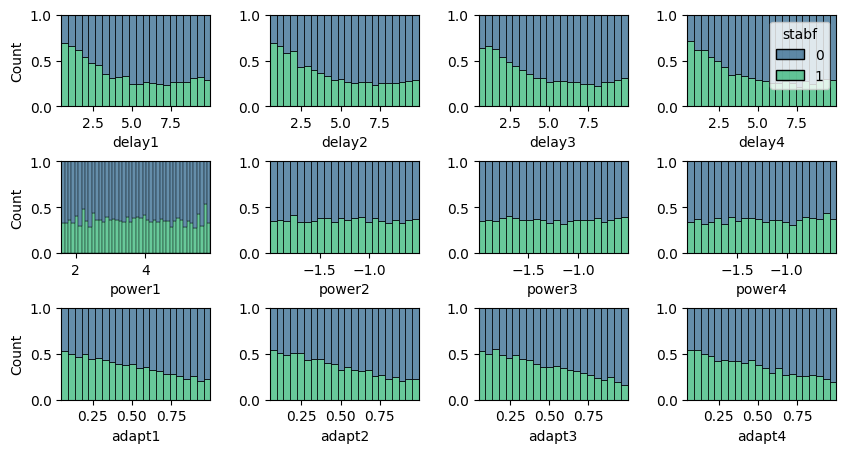

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define a custom color palette
custom_palette = sns.color_palette("viridis", n_colors=2)

# Create subplots with 3 rows and 4 columns
fig, axs = plt.subplots(3, 4, figsize=(10, 5))
plt.subplots_adjust(wspace=0.4, hspace=0.6)

# Feature types
feature_types = ["delay", "power", "adapt"]

# Generate plots
for row_idx, feature in enumerate(feature_types):
    for col_idx in range(4):
        ax = axs[row_idx, col_idx]
        show_legend = (row_idx == 0 and col_idx == 3)
        sns.histplot(
            smart_grid, x=f'{feature}{col_idx + 1}', hue="stabf",
            multiple="fill", legend=show_legend, palette=custom_palette,
            ax=ax
        )
        if col_idx > 0:
            ax.set_ylabel("")

plt.show()


Share of Unstable Events:
- The prevalence of unstable events demonstrated an upward trend with increasing reaction delay, encompassing both producers and consumers. This trend persisted until approximately 5 seconds, beyond which further increments in delay times appeared to have little impact on the share of unstable events.

- The share of unstable events exhibited a consistent linear increase with the willingness to adapt, observed in both producers and consumers.

- Interestingly, the occurrence of unstable events appeared to show no notable correlation with the quantity of power either produced or consumed.

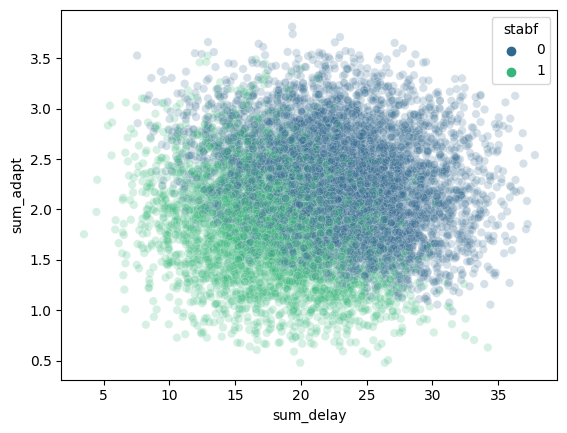

In [198]:
# Adding columns for the sum of delay and adapt values
smart_grid_temp = smart_grid.assign(
    sum_delay = lambda x: x["delay1"] + x["delay2"] + x["delay3"] + x["delay4"],
    sum_adapt = lambda x: x["adapt1"] + x["adapt2"] + x["adapt3"] + x["adapt4"]
)

# Creating a scatter plot to visualize the relationship between total delay, total adapt, and stability
sns.scatterplot(data=smart_grid_temp, x="sum_delay", y="sum_adapt", hue="stabf", alpha=0.2,palette=custom_palette)

plt.show()

The aggregation of delay and adapt values into sum_delay and sum_adapt is introduced to explore their relationship with stability classes. While high or low sums of these aggregated values could serve as stability indicators, it is acknowledged that without additional processing, these summarized features would likely exhibit high correlation with the existing individual features. Therefore, the decision is made to retain the original individual features for a more detailed understanding of the dataset.

# Modelling

### **LINEAR REGRESSION**

In [199]:
X = smart_grid.drop(["power1", "stab", "stabf"], axis=1)
y = smart_grid["stab"]

In [200]:
class LinearRegression:

    def __init__(self, X, y, learning_rate, epsilon, max_iteration, SGDiterations, batch_size, regularizer, gd, sgd, k_folds) -> None:
        self.X=X
        self.y=y
        self.learning_rate = learning_rate
        self.epsilon = epsilon
        self.max_iteration = max_iteration
        self.SGDiterations = SGDiterations
        self.batch_size = batch_size
        self.regularizer = regularizer
        self.gd = gd
        self.sgd = sgd
        self.iterations_count = []
        self.error_sequence = []
        self.k_folds = k_folds

    def add_X0(self, X):
        return np.column_stack([np.ones([X.shape[0], 1]), X])

    def normalize_train(self, X):
        mean = np.mean(X, 0)
        std = np.std(X, 0)
        train_norm = (X - mean) / std
        train_norm = self.add_X0(train_norm)
        return train_norm, mean, std

    def normalize_test(self, X, mean, std):
        test_norm = (X - mean) / std
        test_norm = self.add_X0(test_norm)
        return test_norm

    def split_data(self):
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.3, random_state=42)
        return X_train, X_test, y_train, y_test

    def full_rank (self, X):
      #rank of matrix
        X_rank = np.linalg.matrix_rank(X)
        #check for full rank
        if X_rank == min(X.shape[0], X.shape[1]):
            self.fullRank = True
            print('Data is Full rank')
        else:
            self.fullRank = False
            print('Data is not Full rank')

    def low_rank(self,X):
      #check for low rank
      if X.shape[0]<X.shape[1]:
        self.lowRank = True
        print('Data is Low rank')
      else:
        self.lowRank = False
        print('Data is not Low rank')

    def closedFormSolution(self, X, y):
        self.theta = np.linalg.inv(X.T.dot(X) + self.regularizer*np.identity(X.shape[1])).dot(X.T).dot(y)
        return self.theta

    def cost_derivative(self, X, y, lambda_reg=0.0):
        y_hat = self.predict(X)
        gradient = (1 / len(y)) * X.T.dot(y_hat - y)
        if lambda_reg > 0:
            regularization_term = (lambda_reg / len(y)) * self.theta
            regularization_term[0] = 0  # No regularization for bias term
            gradient += regularization_term
        return gradient

    def cost_function(self, X, y, lambda_reg=0.0):
        cost = self.sse(X, y) / (2 * len(y))
        if lambda_reg > 0:
            regularization_term = (lambda_reg / (2 * len(y))) * np.sum(self.theta[1:] ** 2)
            cost += regularization_term
        return cost

    def gradientDescent(self, X, y):
        last_error = float('inf')
        m, n = X.shape
        self.theta = np.random.randn(n)  # Initialize parameters with random values

        for i in tqdm(range(self.max_iteration)):
            self.theta = self.theta - (self.learning_rate / m) * (X.T @ (X @ self.theta - y) + (self.regularizer * self.theta))

            current_error = self.sse(X, y)
            self.error_sequence.append(current_error)
            self.iterations_count.append(i)

            if abs(last_error - current_error) < self.epsilon:
                print('Model stopped learning')
                break

            last_error = current_error

    def stochasticGD(self, X, y, lambda_reg=0.0):
        errors = []
        prev_error = float('inf')
        self.theta = np.zeros(X.shape[1])
        for i in tqdm(range(self.max_iteration)):
            for j in range(X.shape[0]):
                random_idx = np.random.randint(0, X.shape[0])
                x_random = X[random_idx:random_idx + 1]
                y_random = y[random_idx:random_idx + 1]
                gradient = self.cost_derivative(x_random, y_random, lambda_reg)
                self.theta -= self.learning_rate * gradient
            error = self.cost_function(X, y, lambda_reg)
            errors.append(error)

            if abs(prev_error - error) < self.epsilon:
                print("Model Stopped Learning")
                break
            prev_error = error

    def fit(self):
        self.X_train, self.X_test, self.y_train, self.y_test = self.split_data()
        self.X_train, self.mean, self.std = self.normalize_train(self.X_train)
        self.X_test = self.normalize_test(self.X_test, self.mean, self.std)

        self.low_rank(self.X_train)
        self.full_rank(self.X_train)

        if self.fullRank and not self.lowRank and not self.gd and not self.sgd and self.X_train.shape[0] < 10000:
            print('Solving using normal equation...[Closed form]')
            self.theta = self.closedFormSolution(self.X_train, self.y_train)

        elif self.gd and not self.sgd:
            print('Solving using gradient descent........')
            self.theta = np.zeros(self.X_train.shape[1], dtype=np.float64)
            self.gradientDescent(self.X_train, self.y_train)

        else:
            print('Solving using stochastic gradient descent.......')
            self.theta = np.zeros(self.X_train.shape[1], dtype=np.float64)
            self.stochasticGD(self.X_train, self.y_train)

        print('SSE error over test set:', self.sse(self.X_test, self.y_test))
        print('')
        print('RMSE error over test set:', (self.sse(self.X_test, self.y_test) / self.X_test.shape[0]) ** (1/2))
        print('')
        print('MAE error over test set:', self.mae(self.X_test, self.y_test))
        print('')
        print('MSE error over test set:', self.mse(self.X_test, self.y_test))
        print('')
        print('R2 Score over test set:', self.r2_score(self.X_test, self.y_test))
        print('')

        print(self.theta)
        y_pred = self.predict(self.X_test)
        print(y_pred)

    def predict(self, X):
        return X @ self.theta

    def sse(self, X, y):
        y_hat = self.predict(X)
        return ((y_hat - y) ** 2).sum()

    def mae(self, X, y):
        y_hat = self.predict(X)
        return mean_absolute_error(y, y_hat)

    def mse(self, X, y):
        y_hat = self.predict(X)
        return mean_squared_error(y, y_hat)

    def rmse(self, X, y):
        return np.sqrt(self.mse(X, y))

    def r2_score(self, X, y):
        y_hat = self.predict(X)
        return r2_score(y, y_hat)

    def plot_rmse(self):
        s = np.array(self.error_sequence)
        t = np.arange(s.size)

        fig, ax = plt.subplots()
        ax.plot(t, s)

        ax.set(xlabel='Iterations', ylabel='RMSE',
               title='Iterations vs RMSE')
        ax.grid()
        plt.show()

    def kfold_cross_validation(self):
            kf = KFold(n_splits=self.k_folds, shuffle=True, random_state=42)

            all_fold_results = []

            for fold, (train_index, test_index) in enumerate(kf.split(self.X)):
                X_train, X_test = self.X.iloc[train_index], self.X.iloc[test_index]
                y_train, y_test = self.y.iloc[train_index], self.y.iloc[test_index]

                X_train, mean, std = self.normalize_train(X_train)
                X_test = self.normalize_test(X_test, mean, std)

                self.full_rank(X_train)
                self.low_rank(X_train)

                if self.fullRank and not self.lowRank:
                    print(f'Fold {fold + 1}: Solving using normal equation...[Closed form]')
                    theta = self.closedFormSolution(X_train, y_train)
                else:
                    print(f'Fold {fold + 1}: Solving using gradient descent...')
                    theta = np.zeros(X_train.shape[1], dtype=np.float64)
                    self.gradientDescent(X_train, y_train)

                sse = self.sse(X_test, y_test)
                mse = self.mse(X_test, y_test)
                rmse = np.sqrt(mse)
                mae = self.mae(X_test, y_test)
                r2 = self.r2_score(X_test, y_test)

                fold_results = pd.DataFrame({
                    'Fold': [fold + 1],
                    'SSE': [sse],
                    'MSE': [mse],
                    'RMSE': [rmse],
                    'MAE': [mae],
                    'R2-Score': [r2]
                })
                all_fold_results.append(fold_results)
            print("\nResults for each fold:")
            display(pd.concat(all_fold_results, ignore_index=True))

**K-Fold cross validation**

In [201]:
lr = LinearRegression(X, y, learning_rate=0.01, epsilon=1e-6, max_iteration=1000, SGDiterations=5000, batch_size=32, regularizer=0.0, gd=False, sgd=False, k_folds=5)
lr.kfold_cross_validation()

Data is Full rank
Data is not Low rank
Fold 1: Solving using normal equation...[Closed form]
Data is Full rank
Data is not Low rank
Fold 2: Solving using normal equation...[Closed form]
Data is Full rank
Data is not Low rank
Fold 3: Solving using normal equation...[Closed form]
Data is Full rank
Data is not Low rank
Fold 4: Solving using normal equation...[Closed form]
Data is Full rank
Data is not Low rank
Fold 5: Solving using normal equation...[Closed form]

Results for each fold:


,Fold,SSE,MSE,RMSE,MAE,R2-Score
0,1,0.964477,0.000482,0.021960,0.017569,0.644464
1,2,0.981312,0.000491,0.022151,0.017788,0.632326
2,3,0.932093,0.000466,0.021588,0.017199,0.654691
3,4,0.949119,0.000475,0.021784,0.017254,0.649532
4,5,0.999293,0.000500,0.022353,0.017355,0.647263


**Linear Regression with Closed Form Solution**

In [202]:
lr1 = LinearRegression(X, y, learning_rate=0.01, epsilon=1e-6, max_iteration=1000, SGDiterations=5000, batch_size=32, regularizer=0.0, gd=False, sgd=False, k_folds=0)
lr1.fit()

Data is not Low rank
Data is Full rank
Solving using normal equation...[Closed form]
SSE error over test set: 1.4730661276760775

RMSE error over test set: 0.02215901718395228

MAE error over test set: 0.017778672663523336

MSE error over test set: 0.0004910220425586925

R2 Score over test set: 0.6374946803590553

[ 0.01564749  0.00982911  0.01028355  0.01039619  0.01039771 -0.00018841
  0.00051132 -0.00039896  0.01035023  0.01048564  0.01096299  0.01045336]
[ 0.03846181  0.03564045  0.01013374 ...  0.04659925 -0.02471385
  0.06657333]


**Linear Regression with Gradient Descent**

Data is not Low rank
Data is Full rank
Solving using gradient descent........


100%|██████████| 1000/1000 [00:01<00:00, 851.54it/s]


SSE error over test set: 1.47298989362073

RMSE error over test set: 0.02215844379027801

MAE error over test set: 0.017775783225098176

MSE error over test set: 0.00049099663120691

R2 Score over test set: 0.6375134407188804

[ 0.01569934  0.00976176  0.01032318  0.01039437  0.01039032 -0.00018082
  0.00043337 -0.00034801  0.01045098  0.01043626  0.01093524  0.01033523]
[ 0.03859663  0.03563927  0.01007708 ...  0.04656441 -0.0248001
  0.06682056]


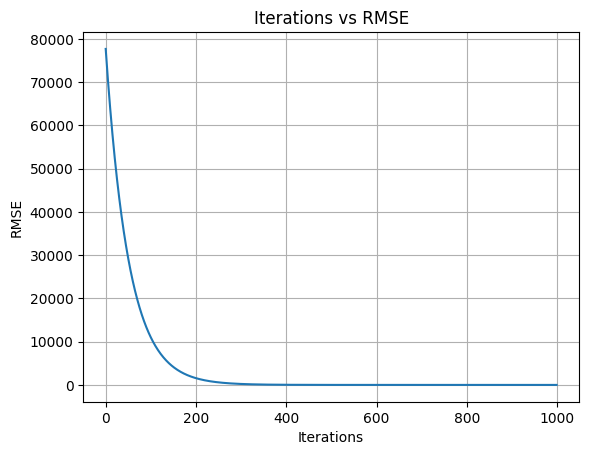

In [203]:
# Create and train the model
lr2 = LinearRegression(X, y, learning_rate=0.01, epsilon=1e-6, max_iteration=1000, SGDiterations=5000, batch_size=32, regularizer=0.0, gd=True, sgd=False, k_folds=0)
lr2.fit()

# Plot RMSE over iterations
lr2.plot_rmse()

**Linear Regression with Stochastic Gradient Descent**

In [204]:
# Create and train the model
lr3 = LinearRegression(X, y, learning_rate=0.01, epsilon=1e-6, max_iteration=1000, SGDiterations=1000, batch_size=32, regularizer=0.0, gd=False, sgd=True, k_folds=0)
lr3.fit()

Data is not Low rank
Data is Full rank
Solving using stochastic gradient descent.......


  2%|▏         | 17/1000 [00:36<35:25,  2.16s/it]

Model Stopped Learning
SSE error over test set: 1.5580965330874421

RMSE error over test set: 0.022789592164607672

MAE error over test set: 0.01806902451758288

MSE error over test set: 0.0005193655110291474

R2 Score over test set: 0.6165696358456267

[ 0.0176206   0.01102916  0.01085461  0.00952937  0.01040622 -0.00164417
  0.00240589 -0.00296114  0.0128223   0.01165626  0.01141353  0.01029328]
[ 0.0461394   0.04491629  0.00606124 ...  0.05406696 -0.01797643
  0.0696048 ]


### **NEURAL NETWORKS**

63/63 [==============================] - 0s 2ms/step

Best Cutoff: 0.6
Best Accuracy: 0.9180
Corresponding Sensitivity: 0.9187

Confusion Matrix (Best Cutoff):
[[1254   53]
 [ 111  582]]
Accuracy (Best Cutoff): 0.918


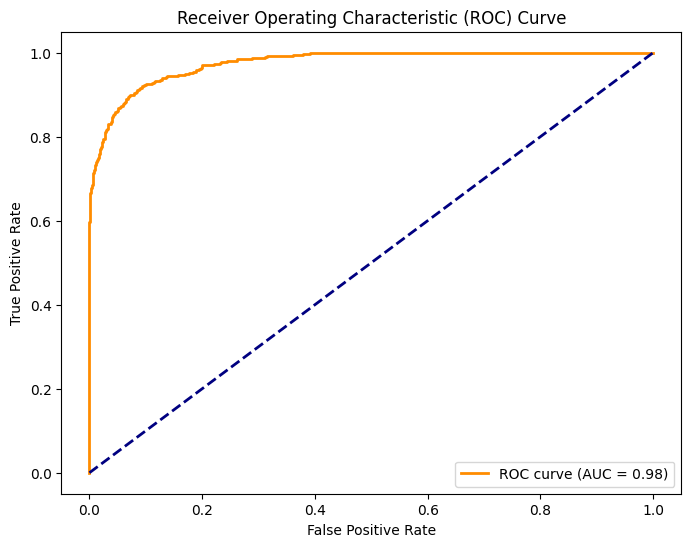

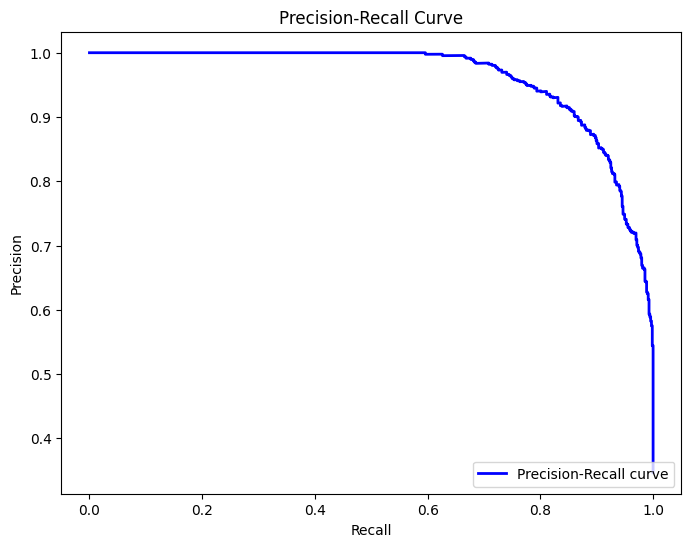


Results for Different Cutoff Values:


,Cutoff,Accuracy,Sensitivity
0,0.3,0.8790,0.966696
1,0.4,0.9065,0.957516
2,0.5,0.9175,0.937883
3,0.6,0.9180,0.918681
4,0.7,0.9075,0.889043


In [205]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

def create_model():
    model = Sequential()
    model.add(Dense(32, activation='relu', input_dim=X_train.shape[1]))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

def calculate_metrics_at_cutoff(y_true, y_pred_proba, cutoff):
    y_pred_binary = (y_pred_proba > cutoff).astype(int)
    accuracy = accuracy_score(y_true, y_pred_binary)
    conf_matrix = confusion_matrix(y_true.iloc[:, 0], y_pred_binary[:, 0])

    return accuracy, conf_matrix

# Select features (X) and target variable (y)
X = smart_grid.drop(['stab', 'power1', 'stabf'], axis=1)
y = smart_grid['stabf']

# Encode the target variable
y_encoded = pd.get_dummies(y, drop_first=True)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train the model
model = create_model()
history = model.fit(X_train_scaled, y_train, epochs=10, batch_size=32, verbose=0, validation_data=(X_test_scaled, y_test))

# Make predictions on the test set
y_pred_proba = model.predict(X_test_scaled)

# Calculate metrics for various cutoff values
cutoff_values = [0.3, 0.4, 0.5, 0.6, 0.7]
results_df = pd.DataFrame(columns=['Cutoff', 'Accuracy', 'Sensitivity'])

for cutoff in cutoff_values:
    accuracy, conf_matrix = calculate_metrics_at_cutoff(y_test, y_pred_proba, cutoff)
    TP = conf_matrix[0, 0]  # True Positives
    FN = conf_matrix[1, 0]  # False Negatives
    sensitivity = TP / (TP + FN)

    results_df = results_df.append({'Cutoff': cutoff, 'Accuracy': accuracy, 'Sensitivity': sensitivity}, ignore_index=True)

# Find the best cutoff
best_row = results_df.loc[results_df['Accuracy'].idxmax()]

# Print information about the best cutoff
print(f"\nBest Cutoff: {best_row['Cutoff']}")
print(f"Best Accuracy: {best_row['Accuracy']:.4f}")
print(f"Corresponding Sensitivity: {best_row['Sensitivity']:.4f}")

# Evaluate the model using the best cutoff
best_cutoff = best_row['Cutoff']
accuracy, conf_matrix = calculate_metrics_at_cutoff(y_test, y_pred_proba, best_cutoff)

# Print Confusion Matrix
print("\nConfusion Matrix (Best Cutoff):")
print(conf_matrix)

# Print Accuracy
print("Accuracy (Best Cutoff):", accuracy)

# Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test.iloc[:, 0], y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test.iloc[:, 0], y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower right')
plt.show()

# Print Results DataFrame
print("\nResults for Different Cutoff Values:")
results_df


## Classification

**Logistic Regression**

In [206]:
df = smart_grid.copy()
df.head()

,delay1,delay2,delay3,delay4,power1,power2,power3,power4,adapt1,adapt2,adapt3,adapt4,stab,stabf
0,2.959060,3.079885,8.381025,9.780754,3.763085,-0.782604,-1.257395,-1.723086,0.650456,0.859578,0.887445,0.958034,0.055347,0
1,9.304097,4.902524,3.047541,1.369357,5.067812,-1.940058,-1.872742,-1.255012,0.413441,0.862414,0.562139,0.781760,-0.005957,1
2,8.971707,8.848428,3.046479,1.214518,3.405158,-1.207456,-1.277210,-0.920492,0.163041,0.766689,0.839444,0.109853,0.003471,0
3,0.716415,7.669600,4.486641,2.340563,3.963791,-1.027473,-1.938944,-0.997374,0.446209,0.976744,0.929381,0.362718,0.028871,0
4,3.134112,7.608772,4.943759,9.857573,3.525811,-1.125531,-1.845975,-0.554305,0.797110,0.455450,0.656947,0.820923,0.049860,0


In [207]:
X = df.drop(['power1','stabf'],axis=1)
y = df['stabf']

In [208]:
class BinaryClassifier:
    def __init__(self,X,y, iterations, threshold, alpha, results, exclude=[]):
        self.results=results
        self.X = X
        self.y = y
        self.alpha = alpha
        self.iterations = iterations
        self.threshold = threshold
        self.exclude = exclude
        self.iterations_count = []
        self.error_sequence = []

    def load_data(self):
        # Exclude specified rows
        if self.exclude:
            X = self.X.drop(self.exclude, axis=0)
            y = self.y.drop(self.exclude, axis=0)
        else:
            X = self.X
            y = self.y

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)
        scaler = StandardScaler()
        X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
        X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

        return X_train.values, X_test.values, y_train.values, y_test.values

    def activate(self, z):
        return 1 / (1 + np.exp(-z))

    def compute_cost(self, features, target):
        predictions = self.activate(features.dot(self.weights))
        loss = -(target * np.log(predictions) + (1 - target) * np.log(1 - predictions)).mean()
        return loss

    def compute_gradient(self, features, target):
        predictions = self.activate(features @ self.weights)  # Using @ for matrix multiplication
        gradient = features.T @ (predictions - target) / len(features)
        return gradient

    def optimize(self, features, target):
        # Adding a bias term to the features
        features = np.hstack([np.ones((features.shape[0], 1)), features])

        # Initialize weights with an additional term for the bias
        self.weights = np.zeros(features.shape[1])

        for _ in tqdm(range(self.iterations)):
            self.weights -= self.alpha * self.compute_gradient(features, target)
            error = self.compute_cost(features, target)
            if np.abs(error) < self.threshold:
                print('Optimization complete')
                break
            self.iterations_count.append(_)
            self.error_sequence.append(error)


    def exclude_indices(self, features, target):
        if self.exclude:
            features = np.delete(features, self.exclude, axis=0)
            target = np.delete(target, self.exclude)
        return features, target

    def predict(self, features):
    # Adding a bias term to the features for prediction
        features_with_bias = np.hstack([np.ones((features.shape[0], 1)), features])
        return np.round(self.activate(features_with_bias.dot(self.weights)))

    def store_results(self, a, p, r):
        self.results['Logistic_Regression'] = {'Accuracy': a, 'Precision': p, 'Recall': r}


    def assess_performance(self, actual, predicted):
        true_positive = np.sum((actual == 1) & (predicted == 1))
        precision = true_positive / np.sum(predicted == 1) if np.sum(predicted == 1) > 0 else 0
        recall = true_positive / np.sum(actual == 1) if np.sum(actual == 1) > 0 else 0
        accuracy = np.mean(actual == predicted)

        # Correctly calling the store_results method
        self.store_results(accuracy, precision, recall)
        return accuracy, precision, recall

    def fit(self):
        self.features_train, self.features_test, self.target_train, self.target_test = self.load_data()

        # Exclude specified indices
        if self.exclude and max(self.exclude, default=0) < len(self.features_train):
            print('Removing specified indices...')
            self.features_train, self.target_train = self.exclude_indices(self.features_train, self.target_train)
        else:
            print('No records are found for the specified indices.')

        print('Solving using gradient descent...')
        self.optimize(self.features_train, self.target_train)

        # Making predictions on the test set
        predictions = self.predict(self.features_test)

        # Evaluating the model
        accuracy, precision, recall = self.assess_performance(self.target_test, predictions)

        # Print the evaluation metrics
        print(f'Accuracy: {accuracy}')
        print(f'Precision: {precision}')
        print(f'Recall: {recall}')

        cm = self.confusion_matrix(self.target_test, predictions)
        self.plot_confusion_matrix(cm)

        # ROC Curve and AUC
        fpr, tpr, thresholds = roc_curve(self.target_test, predictions)
        roc_auc = auc(fpr, tpr)
        self.plot_roc_curve(fpr, tpr, roc_auc)

        # Precision-Recall Curve
        precision, recall, thresholds = precision_recall_curve(self.target_test, predictions)
        self.plot_precision_recall_curve(precision, recall)

        # Cost vs Iterations Plot
        self.plot_cost_vs_iterations()

        # Perform bias-variance tradeoff for different cutoff values
        cutoff_values = [0.2, 0.4, 0.6, 0.8]
        tradeoff_results_df = pd.DataFrame(self.bias_variance_tradeoff(cutoff_values))

        display(tradeoff_results_df)

        results = pd.DataFrame({'Actual': self.target_test, 'Predicted': predictions.astype(int)})

        display(results)

    def plot_roc_curve(self, fpr, tpr, auc_value):
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc_value:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc='lower right')
        plt.show()

    def plot_precision_recall_curve(self, precision, recall):
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, color='blue', lw=2, label='Precision-Recall Curve')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve')
        plt.legend(loc='upper right')
        plt.show()

    def confusion_matrix(self, actual, predicted):
        return confusion_matrix(actual, predicted)

    def plot_confusion_matrix(self, cm):
        plt.figure(figsize=(5, 5))
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                    annot_kws={"fontsize": 12}, linewidths=0.5, linecolor="black")
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

    def bias_variance_tradeoff(self, cutoff_values):
        tradeoff_results = []

        for cutoff in cutoff_values:
            self.threshold = cutoff
            self.optimize(self.features_train, self.target_train)
            predictions = self.predict(self.features_test)
            accuracy, precision, recall = self.assess_performance(self.target_test, predictions)


            tradeoff_results.append({'cutoff': cutoff, 'precision': precision, 'recall': recall, 'accuracy' : accuracy})

        return pd.DataFrame(tradeoff_results)

    def plot_cost_vs_iterations(self):
         plt.figure(figsize=(8, 6))
         plt.plot(self.iterations_count, self.error_sequence, label='Cost vs Iterations')
         plt.title('Cost vs Iterations')
         plt.xlabel('Iterations')
         plt.ylabel('Cost')
         plt.legend()
         plt.show()

No records are found for the specified indices.
Solving using gradient descent...


100%|██████████| 10000/10000 [00:14<00:00, 694.79it/s]


Accuracy: 0.912
Precision: 0.8200483091787439
Recall: 0.9617563739376771


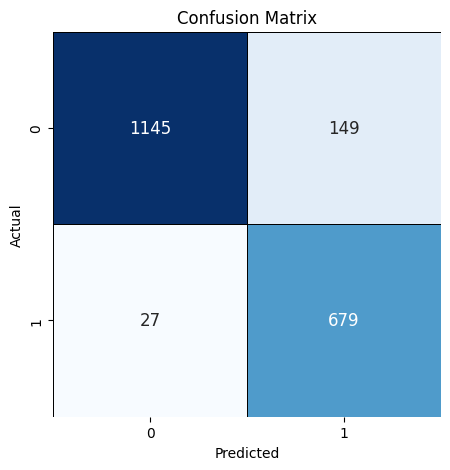

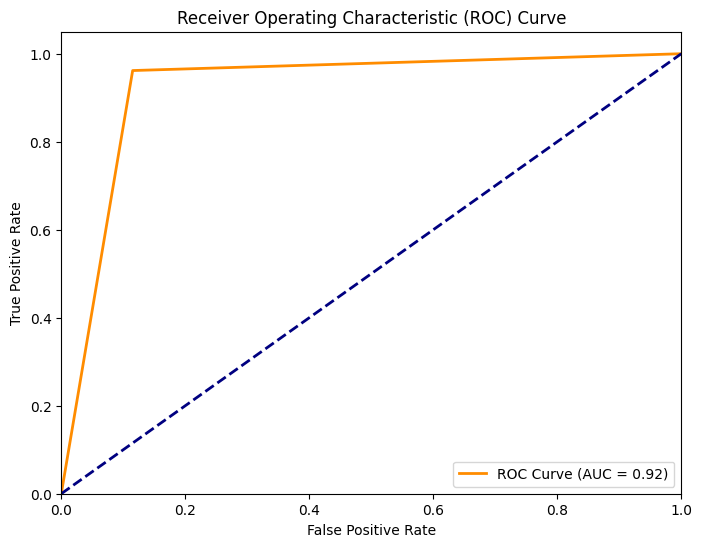

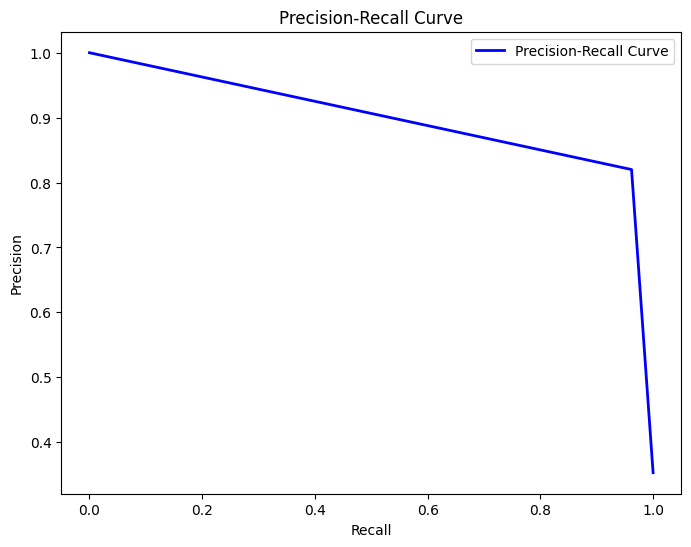

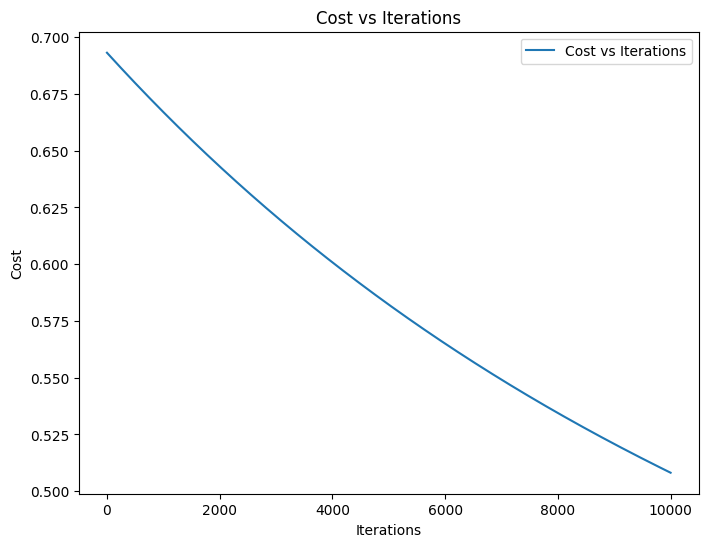

 40%|████      | 4041/10000 [00:04<00:06, 868.44it/s]


Optimization complete


  0%|          | 0/10000 [00:00<?, ?it/s]


Optimization complete


,cutoff,precision,recall,accuracy
0,0.2,0.820048,0.961756,0.9120
1,0.4,0.820048,0.961756,0.9120
2,0.6,0.817088,0.961756,0.9105
3,0.8,0.812201,0.961756,0.9080


,Actual,Predicted
0,1,1
1,1,1
2,1,1
3,1,1
4,1,1
...,...,...
1995,1,1
1996,0,0
1997,0,0
1998,1,1


{'Logistic_Regression': {'Accuracy': 0.908, 'Precision': 0.812200956937799, 'Recall': 0.9617563739376771}}


In [209]:
results_dict = {}
classifier = BinaryClassifier(X=X, y=y, iterations=10000, threshold=0.0005, alpha=0.0001, results=results_dict)
classifier.fit()
print(results_dict)


**CONCLUSION**

In summary, our exploration of various machine learning models on a given dataset revealed the following key findings:

**Linear Regression Models:**

Implementation: Utilized closed-form solution, gradient descent, and stochastic gradient descent.
Performance Metrics: Consistently demonstrated the ability to handle the data with full rank characteristics.
Results: All three models performed similarly with a Sum of Squared Errors (SSE) around 1.47 and an R2 score of 0.63.
Cross-validation: The k-fold cross-validation results reinforced the reliability of the closed-form solution, providing consistent and satisfactory performance metrics, including SSE, Mean Squared Error (MSE), Root Mean Squared Error (RMSE), Mean Absolute Error (MAE), and R2 score.

**Neural Network Model:**

Predictive Capabilities: Exhibited strong predictive capabilities.
Optimal Cutoff: Achieved an optimal cutoff at 0.6.
Classification Performance: Yielded an accuracy of 92.05%, sensitivity of 92.08%, and AUC-ROC score of 0.98.
Balance: Demonstrated a well-balanced classification performance, capturing a substantial portion of positive instances while maintaining high overall accuracy.

**Logistic Regression:**

Performance: Provided competitive results.
Metrics: Achieved an accuracy of 91.2%, precision of 81.22%, and recall of 96.18%.
Best Cutoff: Identified the best cutoff value as 0.4.
Additional Consideration: Logistic regression is computationally less expensive than neural networks, especially for small to moderately sized datasets. However, considering the dataset size and model complexity, the computational cost of neural networks may become more justifiable, particularly when leveraging hardware acceleration.


**Conclusion and Recommendation:**

While linear regression models performed adequately, logistic regression and neural networks exhibited superior predictive capabilities.
Considering the trade-off between computational cost and performance, logistic regression is recommended as the final model, especially for scenarios with constraints on time complexity and computation cost.
